# Pairs Trading - Strategy
- by Chee-Foong
- on May 2020

---
## Summary
An attempt to automate a pairs trading strategy adapted from the article by Auquan - [Pairs Trading using Data-Driven Techniques: Simple Trading Strategies Part 3](https://medium.com/auquan/pairs-trading-data-science-7dbedafcfe5a).

Instead of using stocks, cryptocurrencies are used here.  Data are downloaded from Binance.  The strategy involves looking for cryptocurrencies pairs that are cointegrated through statistical test on training period data.  The best cointegrated pairs during this period will be traded.

In pairs trading, when the buy/sell signal is triggered, the trade to buy the one coin and sell the other coin are executed.  Exposure size to each coin is hedged based on a ratio.  Positions are closed when the close signal is triggered.  Profit and loss are calculated based on prices at the point of trade execution.  Transaction cost in this analysis is not taken into consideration.

---
## Install dependencies

In [1]:
# !pip install statsmodels

     |████████████████████████████████| 8.7 MB 786 kB/s eta 0:00:01     |████████▌                       | 2.3 MB 392 kB/s eta 0:00:17     |███████████████████████████████▎| 8.5 MB 786 kB/s eta 0:00:01
     |████████████████████████████████| 231 kB 3.4 MB/s eta 0:00:01


---
## Loading the libraries

In [2]:
# IMPORTS
import pandas as pd
import numpy as np

import time
import math
import os.path

from tqdm import tnrange, notebook

from datetime import timedelta, datetime
from dateutil import parser

# Import the plotting library
import matplotlib.pyplot as plt
# %matplotlib inline

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import MonthLocator

import seaborn as sns
sns.set()

plt.rcParams.update({'figure.figsize':(15,7), 'figure.dpi':120})
# plt.style.use('ggplot')

---
## Loading the prices downloaded from Binance

In [3]:
prices = pd.read_csv('../data/prices_backup.csv', parse_dates=True, index_col='timestamp')
prices.head()

,BTC,ETH,BNB,BCC,NEO,LTC,ADA,XRP,EOS,XLM,...,BTS,LSK,BNT,LTO,MBL,USD.2,WTC,XZC,CHR,GXS
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-17 04:00:00,4261.48,301.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 04:01:00,4261.48,301.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 04:02:00,4280.56,300.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 04:03:00,4261.48,300.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 04:04:00,4261.48,301.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Extracting basic price information of the cryptocurrencies and exploring price relevance and date range of each coin.

In [4]:
data_info = []

for coin in notebook.tqdm(prices.columns):
    c = {}
    c['coin'] = coin
    c['mindate'] = prices[coin].dropna().index.min()
    c['maxdate'] = prices[coin].dropna().index.max()
    c['days'] = prices[coin].dropna().index.max() - prices[coin].dropna().index.min()
    data_info.append(c)

data_info = pd.DataFrame(data_info).sort_values('maxdate')    


Select list of crypotocurrenices of interest based on relevance and number of days traded in the market.

Filtering criteria:
- Start date - First trading day
- End date - Last trading day
- Number of days in the market

In [5]:
startdate = datetime(2019,9,1)
enddate = datetime(2020,5,1)
numofdays = '180 days'

In [6]:
interested = data_info[(data_info.days > pd.Timedelta(numofdays)) & 
                       (data_info.maxdate > enddate) &
                       (data_info.mindate < startdate)].coin
# list(interested)

In [7]:
data_info[['coin','days','mindate','maxdate']]

,coin,days,mindate,maxdate
14,VEN,119 days 01:38:00,2018-06-22 08:00:00,2018-10-19 09:38:00
3,BCC,373 days 18:31:00,2017-11-11 08:28:00,2018-11-20 02:59:00
0,BTC,1008 days 22:43:00,2017-08-17 04:00:00,2020-05-22 02:43:00
1,ETH,1008 days 22:43:00,2017-08-17 04:00:00,2020-05-22 02:43:00
2,BNB,927 days 22:49:00,2017-11-06 03:54:00,2020-05-22 02:43:00
4,NEO,913 days 23:02:00,2017-11-20 03:42:00,2020-05-22 02:44:00
5,LTC,890 days 23:12:00,2017-12-13 03:32:00,2020-05-22 02:44:00
6,ADA,765 days 22:42:00,2018-04-17 04:02:00,2020-05-22 02:44:00
7,XRP,748 days 18:33:00,2018-05-04 08:11:00,2020-05-22 02:44:00
8,EOS,724 days 21:45:00,2018-05-28 05:00:00,2020-05-22 02:45:00


VEN and BCC are 2 coins that are do not have recent price data.  Most of the coins started in Sep 2019.

In [8]:
prices = prices[interested]
prices.shape

(1452891, 38)

Resampling of prices:
- Daily: D
- Hourly: 1H, 4H, 6H, 12H
- Minutes: 1T, 5T, 30T

For automated trading strategies, trading signals are analysed and triggered at every time sample.  Depending on the daily resampling, this translates to the number of trading opportunities per day.  Eg: 6H will have 4 trading opportunities per day.

In [9]:
prices = prices.resample('4H').pad()
prices.dropna(inplace=True)

Check to ensure that there are no NA prices for analysis

In [10]:
prices.isnull().any().any()

False

In [11]:
prices.head()

,BTC,ETH,BNB,NEO,LTC,ADA,XRP,EOS,XLM,ONT,...,COS,FTM,ONE,ENJ,OMG,GTO,CVC,FUN,WAN,KEY
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-08-27 04:00:00,10189.98,186.40,25.0862,9.576,72.85,0.04902,0.26804,3.5508,0.06832,0.7708,...,0.02363,0.01733,0.01012,0.06721,1.1967,0.01432,0.04600,0.003400,0.3432,0.001624
2019-08-27 08:00:00,10166.14,186.50,25.2800,9.569,73.06,0.04929,0.26860,3.5499,0.06829,0.7682,...,0.02405,0.01631,0.01013,0.06729,1.1952,0.01429,0.04745,0.003106,0.4840,0.001673
2019-08-27 12:00:00,10107.00,185.99,25.2308,9.562,72.79,0.04852,0.26796,3.5333,0.06791,0.7666,...,0.02377,0.01616,0.01036,0.06900,1.1929,0.01388,0.04594,0.002957,0.4610,0.001660
2019-08-27 16:00:00,10199.97,188.70,25.4763,9.605,73.61,0.04904,0.26913,3.5868,0.06811,0.7786,...,0.02443,0.01896,0.01033,0.07003,1.1848,0.01375,0.04658,0.002938,0.4291,0.001620
2019-08-27 20:00:00,10160.13,187.43,25.5459,9.576,72.54,0.04902,0.26858,3.5665,0.06800,0.7857,...,0.02452,0.01989,0.01026,0.07034,1.1765,0.01377,0.04608,0.002991,0.4160,0.001689


In [12]:
prices.tail()

,BTC,ETH,BNB,NEO,LTC,ADA,XRP,EOS,XLM,ONT,...,COS,FTM,ONE,ENJ,OMG,GTO,CVC,FUN,WAN,KEY
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-05-21 08:00:00,9462.03,208.82,16.7238,9.995,43.88,0.05577,0.20007,2.5797,0.06929,0.4871,...,0.00621,0.00521,0.00331,0.17491,1.1747,0.00657,0.02316,0.002745,0.1701,0.001145
2020-05-21 12:00:00,9387.51,207.80,16.5818,9.934,43.99,0.05579,0.19966,2.5688,0.06912,0.4949,...,0.00607,0.00513,0.00338,0.18482,1.2845,0.00666,0.02372,0.002849,0.1750,0.001070
2020-05-21 16:00:00,9065.81,198.56,16.1113,9.507,42.53,0.05258,0.19264,2.4564,0.06579,0.4619,...,0.00595,0.00472,0.00321,0.17402,1.3071,0.00664,0.02151,0.002700,0.1712,0.000962
2020-05-21 20:00:00,9043.97,198.28,16.1174,9.500,42.69,0.05216,0.19419,2.4616,0.06638,0.4616,...,0.00594,0.00468,0.00320,0.17950,1.4877,0.00597,0.02200,0.002733,0.1684,0.000969
2020-05-22 00:00:00,9048.57,198.30,16.0551,9.532,42.69,0.05197,0.19425,2.4616,0.06656,0.4625,...,0.00611,0.00480,0.00331,0.17757,1.5372,0.00602,0.02255,0.002845,0.1723,0.001013


Splitting the prices to training and testing.  Training dataset to analyse and identify cointegrated pairs and parameters to be use in testing dataset which is unseen or out-of-sample.

Here using Sep to Dec 2019 prices for analysis and to test the trading strategy on Jan to May 2020.

In [13]:
train_prices = prices['2019-09':'2019-12']
test_prices = prices['2020-01':'2020-05']

In [14]:
train_prices.head()

,BTC,ETH,BNB,NEO,LTC,ADA,XRP,EOS,XLM,ONT,...,COS,FTM,ONE,ENJ,OMG,GTO,CVC,FUN,WAN,KEY
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-09-01 00:00:00,9579.62,171.50,21.0574,8.791,64.21,0.04464,0.25745,3.3220,0.06187,0.7058,...,0.02107,0.01670,0.00838,0.06737,1.0878,0.01143,0.04075,0.002695,0.3361,0.001443
2019-09-01 04:00:00,9629.94,172.67,21.4238,8.850,64.89,0.04506,0.25797,3.3202,0.06228,0.7127,...,0.02144,0.01644,0.00846,0.07069,1.0978,0.01226,0.04032,0.002693,0.3396,0.001425
2019-09-01 08:00:00,9608.03,171.88,21.5187,8.861,64.92,0.04471,0.25732,3.3236,0.06220,0.7069,...,0.02016,0.01630,0.00838,0.07002,1.0847,0.01204,0.04089,0.002700,0.3516,0.001446
2019-09-01 12:00:00,9570.28,169.85,21.3547,8.753,64.47,0.04440,0.25447,3.2670,0.06179,0.7040,...,0.02016,0.01629,0.00826,0.07317,1.0771,0.01222,0.04024,0.002689,0.3611,0.001446
2019-09-01 16:00:00,9613.04,170.28,21.3437,8.783,64.84,0.04416,0.25557,3.2852,0.06162,0.7049,...,0.02054,0.01627,0.00830,0.07230,1.0846,0.01224,0.04032,0.002610,0.3629,0.001430


In [15]:
test_prices.head()

,BTC,ETH,BNB,NEO,LTC,ADA,XRP,EOS,XLM,ONT,...,COS,FTM,ONE,ENJ,OMG,GTO,CVC,FUN,WAN,KEY
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,7186.68,129.02,13.7100,8.668,41.20,0.03272,0.19279,2.5832,0.04488,0.5185,...,0.00930,0.01086,0.00457,0.08043,0.6047,0.00872,0.01826,0.003168,0.1719,0.001690
2020-01-01 04:00:00,7224.51,130.18,13.8165,8.713,41.53,0.03301,0.19387,2.6084,0.04517,0.5194,...,0.00948,0.01091,0.00464,0.08052,0.6087,0.00869,0.01801,0.003120,0.1747,0.001694
2020-01-01 08:00:00,7208.39,130.22,13.7511,8.711,41.57,0.03315,0.19433,2.6143,0.04493,0.5197,...,0.00944,0.01083,0.00461,0.07940,0.6078,0.00864,0.01788,0.003146,0.1720,0.001702
2020-01-01 12:00:00,7200.00,130.84,13.7209,8.797,41.60,0.03310,0.19360,2.6196,0.04507,0.5216,...,0.00944,0.01057,0.00468,0.07998,0.6102,0.00865,0.01800,0.003148,0.1746,0.001690
2020-01-01 16:00:00,7236.58,132.27,13.8153,8.947,41.98,0.03360,0.19397,2.6300,0.04539,0.5277,...,0.00945,0.01065,0.00469,0.07957,0.6142,0.00873,0.01786,0.003122,0.1781,0.001660


---
## Finding Cointegration

Cointegration search functions mainly adapted from the article by Auquan - [Pairs Trading using Data-Driven Techniques: Simple Trading Strategies Part 3](https://medium.com/auquan/pairs-trading-data-science-7dbedafcfe5a).

In [16]:
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

In [17]:
def find_cointegrated_pairs(data, conf=0.05):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < conf:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [18]:
def find_cointegrated_pairs_v2(data):
    n = data.shape[1]
    keys = data.keys()

    pairs = []
    scores = []
    pvalues = []
    for i in range(n):
        for j in range(i+1, n):
            try:
                S1 = data[keys[i]]
                S2 = data[keys[j]]
                result = coint(S1, S2)
                scores.append(result[0])
                pvalues.append(result[1])
                pairs.append((keys[i], keys[j]))
            except ValueError as error:
                print(error)
                pass
                      
    return scores, pvalues, pairs

In [19]:
def search_coint_pairs_v2(prices_df, conf=0.05):
    
    scores, pvalues, pairs = find_cointegrated_pairs_v2(prices_df)
    coint_pairs = pd.DataFrame(list(zip(scores, pvalues, pairs)), 
                               columns=['scores','pvalues','pairs'])

    return coint_pairs.sort_values('pvalues')

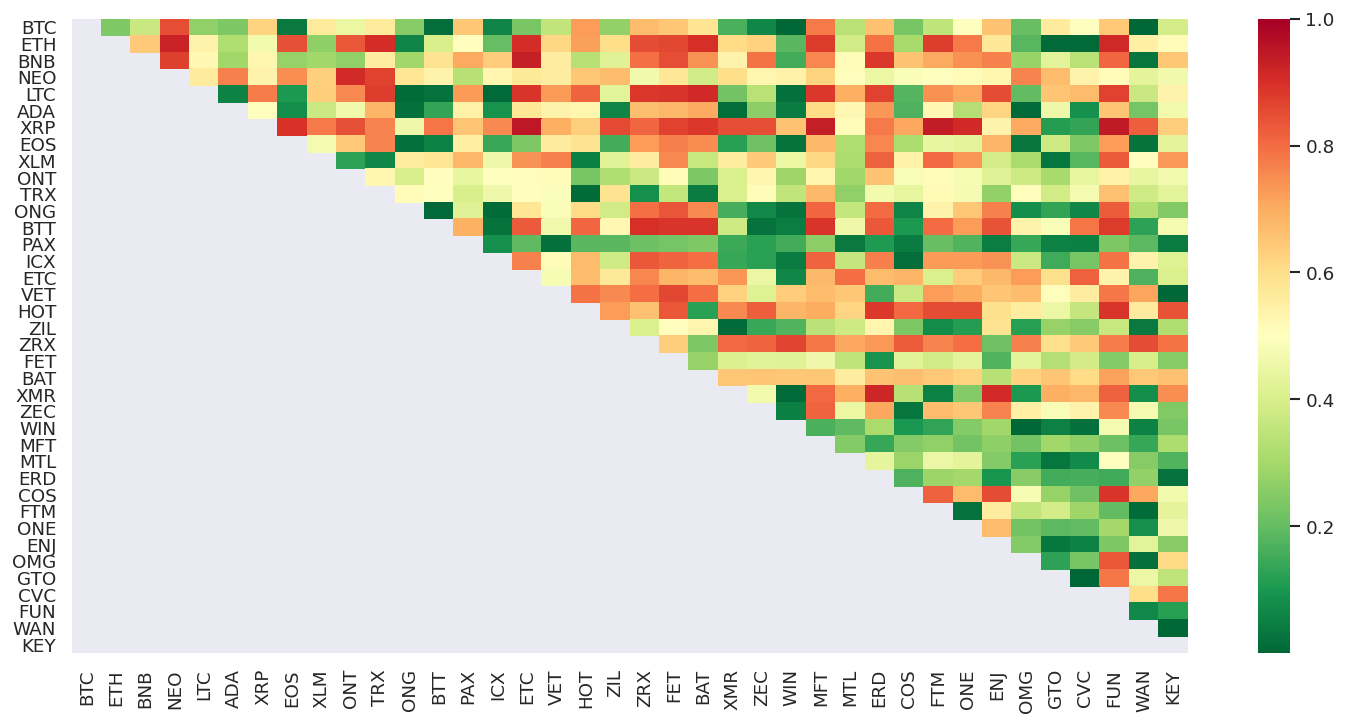

[('BTC', 'EOS'), ('BTC', 'BTT'), ('BTC', 'WIN'), ('BTC', 'WAN'), ('ETH', 'GTO'), ('ETH', 'CVC'), ('BNB', 'WAN'), ('LTC', 'ONG'), ('LTC', 'BTT'), ('LTC', 'ICX'), ('LTC', 'WIN'), ('ADA', 'ONG'), ('ADA', 'XMR'), ('ADA', 'WIN'), ('ADA', 'OMG'), ('EOS', 'ONG'), ('EOS', 'WIN'), ('EOS', 'OMG'), ('EOS', 'WAN'), ('XLM', 'HOT'), ('XLM', 'GTO'), ('TRX', 'HOT'), ('TRX', 'BAT'), ('ONG', 'BTT'), ('ONG', 'ICX'), ('ONG', 'WIN'), ('BTT', 'ICX'), ('BTT', 'ZEC'), ('BTT', 'WIN'), ('PAX', 'VET'), ('PAX', 'MTL'), ('PAX', 'COS'), ('PAX', 'ENJ'), ('PAX', 'CVC'), ('PAX', 'KEY'), ('ICX', 'WIN'), ('ICX', 'COS'), ('VET', 'KEY'), ('ZIL', 'XMR'), ('ZIL', 'WAN'), ('XMR', 'WIN'), ('ZEC', 'WIN'), ('ZEC', 'COS'), ('WIN', 'OMG'), ('WIN', 'CVC'), ('MTL', 'GTO'), ('ERD', 'KEY'), ('FTM', 'ONE'), ('FTM', 'WAN'), ('ENJ', 'GTO'), ('OMG', 'WAN'), ('GTO', 'CVC'), ('WAN', 'KEY')]


In [20]:
# Heatmap to show the p-values of the cointegration test
# between each pair of stocks
scores, pvalues, pairs = find_cointegrated_pairs(train_prices)
m = [0,0.2,0.4,0.6,0.8,1]

plt.figure(figsize=(15,7))

sns.heatmap(pvalues, xticklabels=prices.columns, 
                yticklabels=prices.columns, cmap='RdYlGn_r', 
                mask = (pvalues >= 0.95))

plt.show()
print(pairs)

Cointergrated pairs have p-values close to zero.  Above heatmap shows the list of cointegrated pairs that potentially could be considered for this pair trading strategy.

Selecting the best pair for analysis

In [21]:
top_pairs = search_coint_pairs_v2(train_prices, 0.05).head()

In [22]:
num = 0

P1 = top_pairs.iloc[num].pairs[0]
P2 = top_pairs.iloc[num].pairs[1]
print('Coin 1: {} vs Coin 2: {}'.format(P1, P2))

Coin 1: BTC vs Coin 2: WIN


In [23]:
S1 = train_prices[P1]
S2 = train_prices[P2]

In [24]:
print('Last price of Coin 1: {} vs Last price of Coin 2: {}'.format(S1[-1], S2[-1]))

Last price of Coin 1: 7169.02 vs Last price of Coin 2: 9.18e-05


/usr/local/lib/python3.8/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


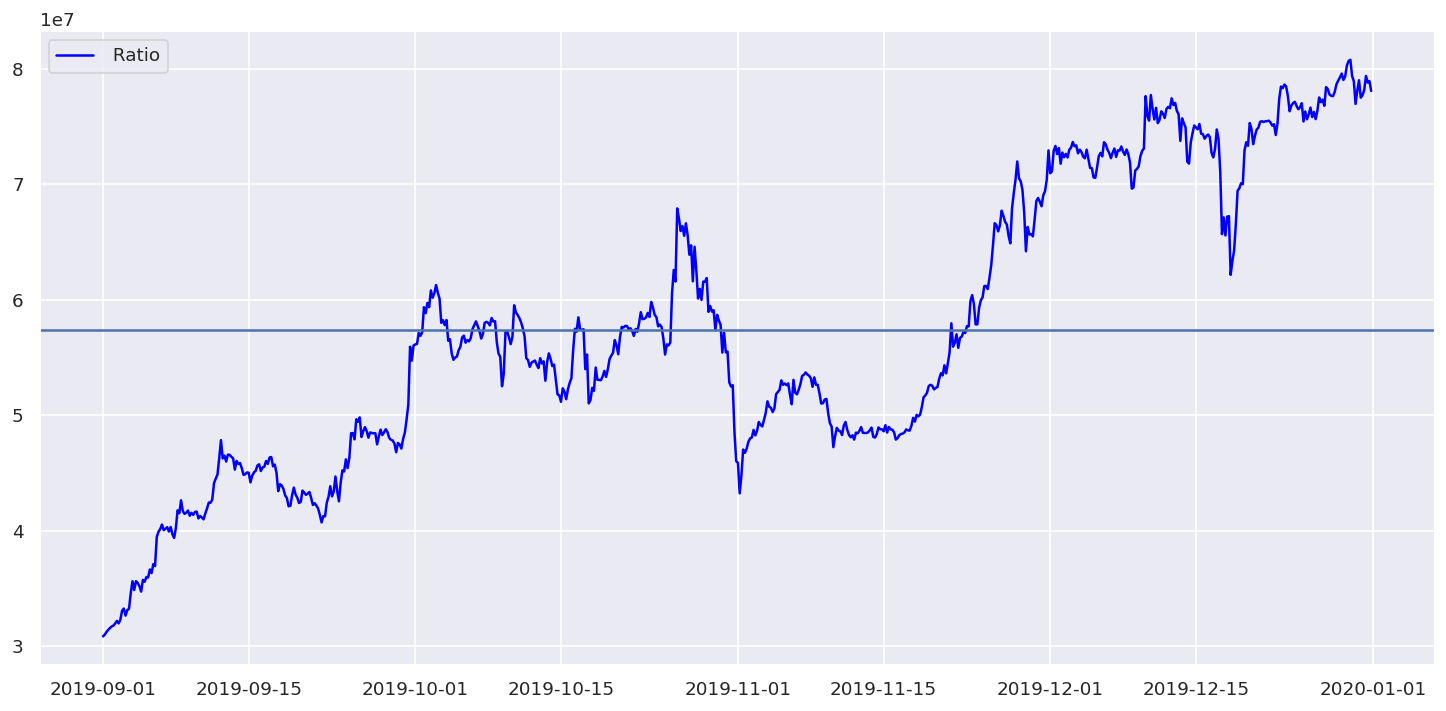

Mean ratio: 57375378.30


In [25]:
score, pvalue, _ = coint(S1, S2)
ratios = S1 / S2

plt.figure(figsize=(15,7))

plt.plot(ratios.index, ratios, color='blue')
plt.axhline(ratios.mean())
plt.legend([' Ratio'])
plt.show()

print('Mean ratio: {:.2f}'.format(ratios.mean()))

We should expect the ratio to move around a stable mean.  Normalising the ratio below.

In [26]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

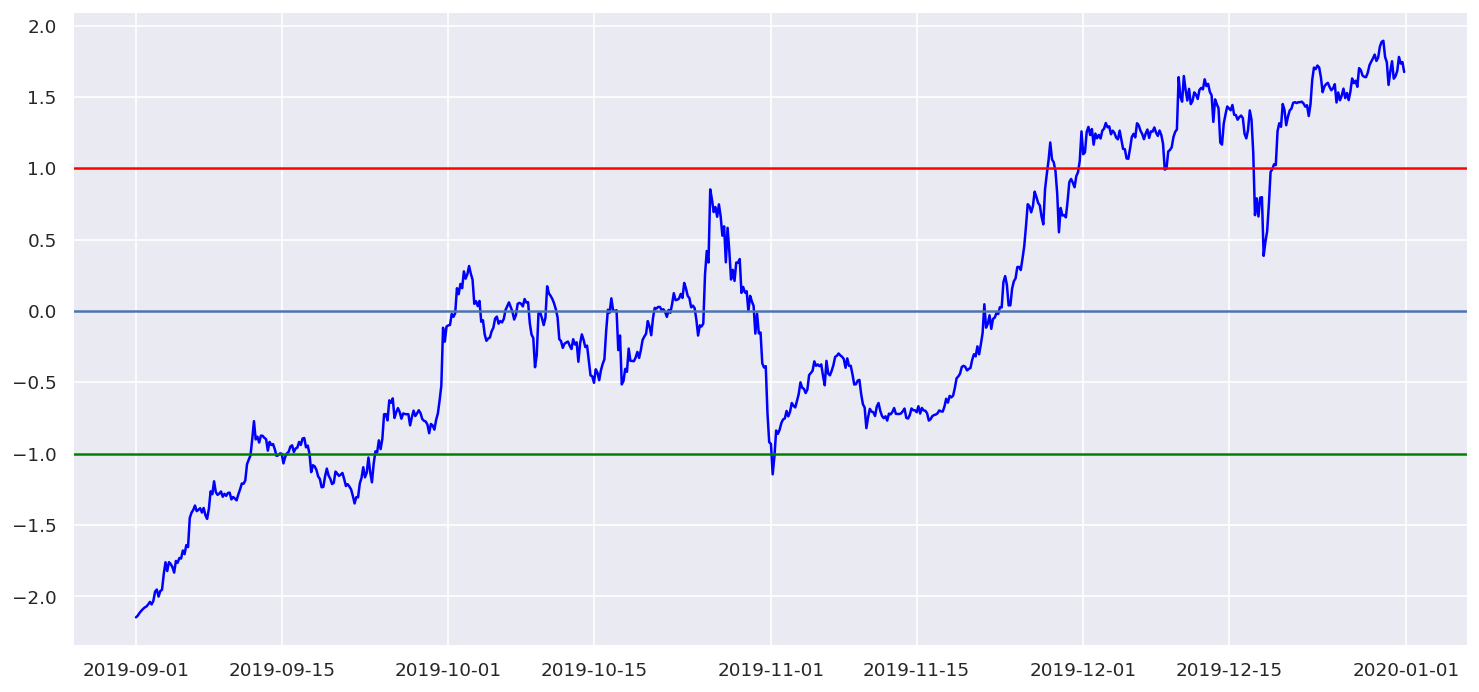

In [27]:
plt.figure(figsize=(15,7))

plt.plot(zscore(ratios).index, zscore(ratios), color='blue')
plt.axhline(zscore(ratios).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.show()

We should expect the ratio's z-score to oscillate between the mean of zero.  When there is huge divergence, there will be trading opportunities.

---
## Feature Engineering

We want to predict the direction of the ratio move.  As the pair are cointegrated, we expect the ratio to revert back to its mean.  Instead of using the mean and standard deviation of the prices over the full training period, we will use rolling moving averages instead.  This way, the most recent data are used to engineer the trading signal.

Using the following features for analysis purposes:
1. Mean (60MA) - 60 days of moving average of ratio
2. Standard Deviation (60SD) - 60 days standard deviation of ratio
3. Latest Ratio (5MA) - 5 days of moving average of ratio
4. Z-Score (Z) - (5MA - 60MA) / 60SD

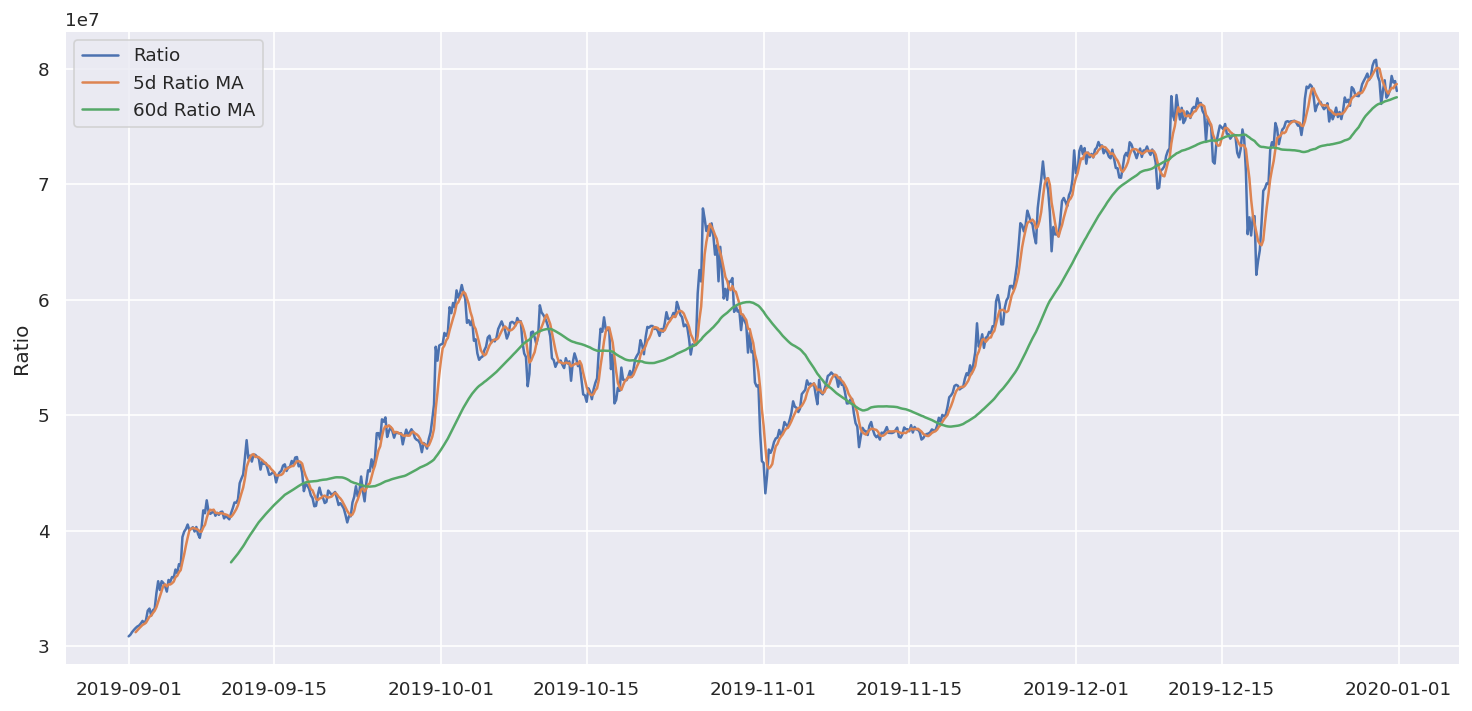

In [28]:
ratios_mavg5 = ratios.rolling(window=5, center=False).mean()
ratios_mavg60 = ratios.rolling(window=60, center=False).mean()
std_60 = ratios.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60

plt.figure(figsize=(15,7))
plt.plot(ratios.index, ratios.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])
plt.ylabel('Ratio')
plt.show()

Visually, we are expecting the orange line to close up (mean-revert) to the green line in the shortest possible time.  While divergence generates trading opportunities, prolonged divergence is not good for the strategy.  Prolonged divergence will lead to:
1. Closing of position as extreme deviated prices leading to potential losses
2. Long holding periods

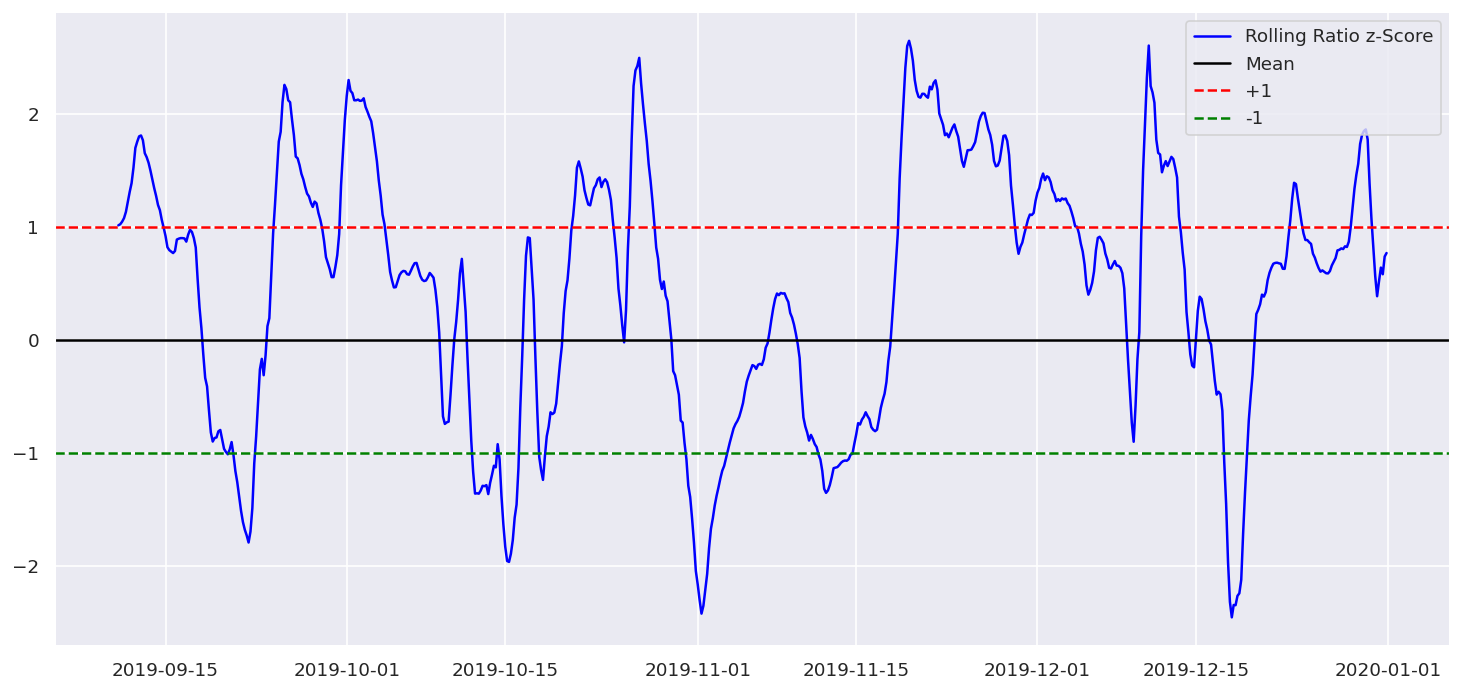

In [29]:
plt.figure(figsize=(15,7))

plt.plot(zscore_60_5.index, zscore_60_5, color='blue')

plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

The Z-Score should mean revert to 0.  Possible trading signal when there is extreme deviation from mean 0.  
- When Z-Score is above the red line, Short: Short Coin 1 and Long Coin 2
- When Z-Score is below the green line, Short: Long Coin 1 and Long Coin 2

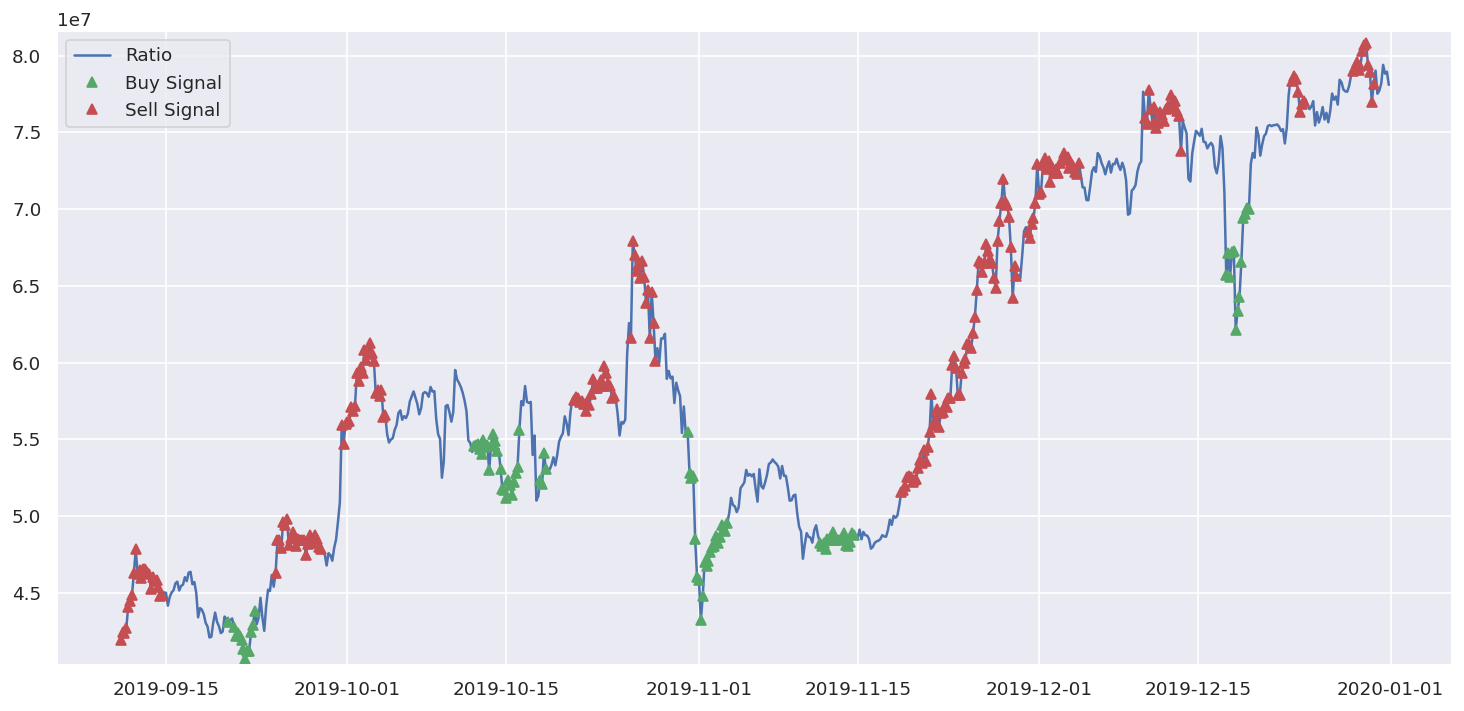

In [30]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))

plt.plot(ratios[60:].index, ratios[60:])

buy = ratios.copy()
sell = ratios.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0

plt.plot(buy[60:].index, buy[60:], color='g', linestyle='None', marker='^')
plt.plot(sell[60:].index, sell[60:], color='r', linestyle='None', marker='^')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios[60:].min()*0.99,ratios[60:].max()*1.01))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

The trading signals to buy and sell.  Green dots are buying signals.  Red dots are selling signals.

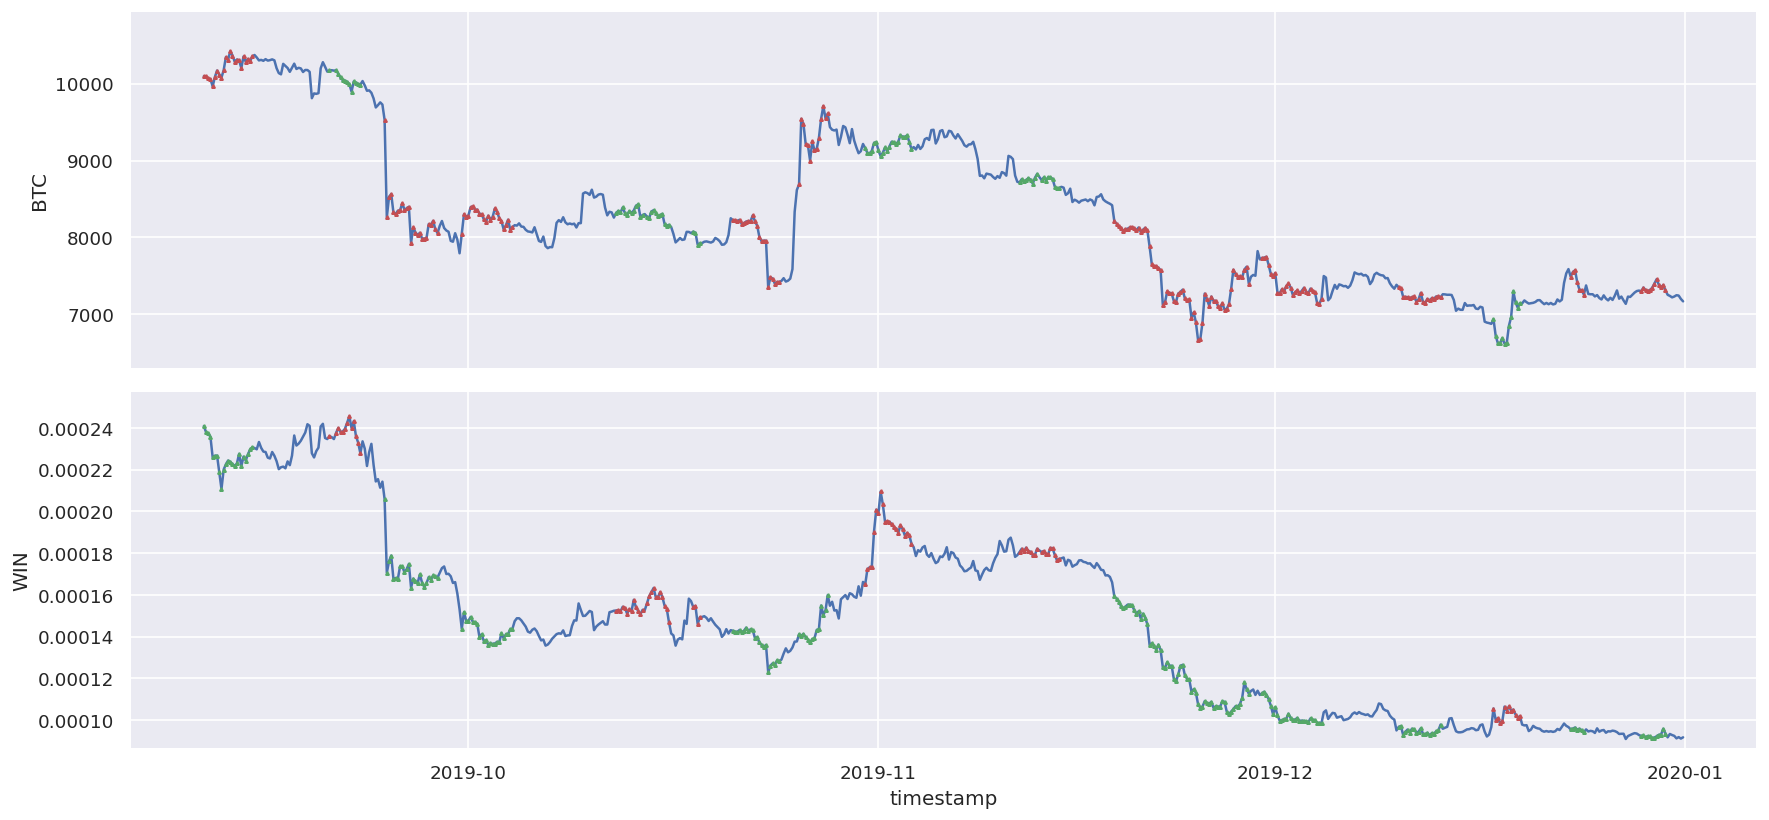

In [31]:
# Plot the prices and buy and sell signals from z score

buyS1 = 0*S1.copy()
sellS1 = 0*S1.copy()
buyS2 = 0*S2.copy()
sellS2 = 0*S2.copy()

# # When buying the ratio, buy S1 and sell S2
buyS1[buy!=0] = S1[buy!=0]
sellS2[buy!=0] = S2[buy!=0]

# # When selling the ratio, sell S1 and buy S2 
buyS2[sell!=0] = S2[sell!=0]
sellS1[sell!=0] = S1[sell!=0]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.set_ylabel(P1)
ax1.plot(S1[60:].index, S1[60:], color='b')
ax1.tick_params(axis='y')
ax1.plot(S1[60:].index, buyS1[60:], color='g', linestyle='None', marker='^', markersize=2)
ax1.plot(S1[60:].index, sellS1[60:], color='r', linestyle='None', marker='^', markersize=2)
ax1.set_ylim([min(S1[60:])*0.95, max(S1[60:])*1.05])

ax2.set_ylabel(P2)  # we already handled the x-label with ax1
ax2.plot(S2[60:].index, S2[60:], color='b')
ax2.tick_params(axis='y')
ax2.plot(S2[60:].index, buyS2[60:], color='g', linestyle='None', marker='^', markersize=2)
ax2.plot(S2[60:].index, sellS2[60:], color='r', linestyle='None', marker='^', markersize=2)
ax2.set_ylim([min(S2[60:])*0.95, max(S2[60:])*1.05])

ax2.set_xlabel('timestamp')

# Define the date format
date_form = DateFormatter("%Y-%m")
ax2.xaxis.set_major_formatter(date_form)
locator = MonthLocator()
ax2.xaxis.set_major_locator(locator)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Similarly, the above plots show that buying and selling signals of each pairs.  It is best to observe both prices move in tandem with minimal deviation.

---
## Trading Strategy

Execute trades when the signal meets the following triggering criterias at any particular time

##### Signal
- **Z Score**: (Near_MA - Far_MA) / Std(Far_MA)

##### Trigger
- **Buy**: When there is no existing position and Z Score < -1  
- **Sell**: When there is no existing position and Z Score > 1
- **Close all**: When there is existing position and Z Score is between -1 and 1 inclusive

##### Trade
*Where n = Price of Coin 1 / Price of Coin 2*
- **Buy Signal**: Buy 1 x Coin 1 and Sell n x Coin 2
- **Sell Signal**: Sell 1 x Coin 1 and Buy n x Coin 2 


The trade function executes the strategy by taking in the following parameters:
1. **P1** - Coin 1 symbol
2. **P2** - Coin 2 symbol
3. **near** - short term moving average period (used as an estimate of current price)
4. **far** - long term moving average period (used as an estimate of mean price in which current price will revert to)
5. **test** - Default is False.  Set to True if you want to use the test dataset.
6. **verbose** - Default is False.  Set to True for debugging.

In [32]:
# Trade using a simple strategy
def trade(P1, P2, near, far, test=False, verbose=False):

    # If window length is 0, algorithm doesn't make sense, so exit
    if (near == 0) or (far == 0) or (near >= far):
        return 0
    
    # Select prices to use: train or test data
    if test:
        if verbose:
            print('Trade on Testing Data')
            print('\n')
        price1 = test_prices[P1]
        price2 = test_prices[P2]    
    else:
        if verbose:
            print('Trade on Training Data')
            print('\n')
        price1 = train_prices[P1]
        price2 = train_prices[P2]
    
    # Compute rolling mean and rolling standard deviation
    # Trading signals for execution
    ratios = price1/price2
    ma1 = ratios.rolling(window=near, center=False).mean()
    ma2 = ratios.rolling(window=far, center=False).mean()
    std = ratios.rolling(window=far, center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    drawdown = 0
    
    # Logging all transactions for validation
    transactions = []
    
    def logTxn(datetime, action1, coin1, price1, qty1,
               action2, coin2, price2, qty2, zscore, hedgeratio, pnl, drawdown=0, holdingperiod=timedelta(0)):
        
        txn = {}
        txn['datetime'] = datetime
        txn['action1'] = action1
        txn['coin1'] = coin1
        txn['price1'] = price1
        txn['qty1'] = qty1
        txn['action2'] = action2
        txn['coin2'] = coin2
        txn['price2'] = price2
        txn['qty2'] = qty2
        txn['zscore'] = zscore
        txn['hedgeratio'] = hedgeratio
        txn['pnl'] = pnl
        txn['drawdown'] = drawdown
        txn['holdingperiod'] = holdingperiod
        
        return txn
    
    # Simulate trading
    # Period by period
    # Trade on trading signals derived based on information only available at the point in time
    for i in range(len(ratios)):

        # Sell short if the z-score is > 1 and when there is no existing position
        if (zscore[i] > 1) & (countS1 == 0) & (countS2 == 0):
            money += price1[i] - price2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            
            opendatetime = ratios.index[i]
            
            transactions.append(
                logTxn(opendatetime, 
                       'Sell', P1, price1[i], countS1,
                       'Buy', P2, price2[i], countS2, 
                       zscore[i], ratios[i], money)
            )
                            
        # Buy long if the z-score is < 1 and when there is no existing position
        elif (zscore[i] < -1) & (countS1 == 0) & (countS2 == 0):
            money -= price1[i] - price2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]

            opendatetime = ratios.index[i]

            transactions.append(
                logTxn(opendatetime, 
                       'Buy', P1, price1[i], countS1,
                       'Sell', P2, price2[i], countS2, 
                       zscore[i], ratios[i], money)
            )
            
        # Close all positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75 and ((countS1 != 0) or (countS2 != 0)):
            money += price1[i] * countS1 + price2[i] * countS2

            closedatetime = ratios.index[i]
            holdingperiod = closedatetime - opendatetime

            transactions.append(
                logTxn(closedatetime, 
                       'Close', P1, price1[i], countS1,
                       'Close', P2, price2[i], countS2, 
                       zscore[i], ratios[i], money, min(money, drawdown), holdingperiod)
            )
            
            countS1 = 0
            countS2 = 0
            drawdown = 0
            
        # Keeps track of maximum drawdown when there are existing positions
        else:            
            drawdown = min(price1[i] * countS1 + price2[i] * countS2, drawdown)
            
    return transactions

In [33]:
def showResults(txn):
    
    txn = pd.DataFrame.from_dict(txn)
    txn = txn[['datetime', 'action1', 'coin1', 'price1', 'qty1',
               'action2', 'coin2', 'price2', 'qty2', 
               'zscore', 'hedgeratio', 'pnl', 'drawdown', 'holdingperiod']]
    txn = txn.set_index('datetime')    
    
    plt.figure(figsize=(15,7))
    plt.plot(txn.pnl.index, txn.pnl)    

    ax = plt.gca()
    formatter = DateFormatter("%Y-%m")
    ax.xaxis.set_major_formatter(formatter)
    locator = MonthLocator()
    ax.xaxis.set_major_locator(locator)    
    
    plt.show()

    print('Profit/Loss: {:.2f}'.format(txn.iloc[-1].pnl))
    print('Maximum Drawdown: {:.2f}'.format(min(txn.drawdown)))
    print('Maximum Holding Period: {}'.format(max(txn.holdingperiod)))
    
    return txn

---
## Parameter Search

Find the optimal near (Near_NA) and far (Far_MA) moving averages that give the best performance and risk profile on training data.

In [34]:
import itertools 

near = list(range(5,15,1))
far = list(range(50,90,1))

combine = [near,far]
params = list(itertools.product(*combine)) 

In [35]:
search_results = []

for param in notebook.tqdm(params):
    result = {}
    txn = trade(P1, P2, param[0], param[1])
    
    txn = pd.DataFrame.from_dict(txn)
    txn = txn[['datetime', 'action1', 'coin1', 'price1', 'qty1',
               'action2', 'coin2', 'price2', 'qty2', 
               'zscore', 'hedgeratio', 'pnl', 'drawdown', 'holdingperiod']]
    txn = txn.set_index('datetime')    

    result['parameter'] = param
    result['PnL'] = txn.iloc[-1].pnl
    result['max_drawdown'] = min(txn.drawdown)
    result['score'] = result['PnL']/abs(result['max_drawdown'])
    
    search_results.append(result)

In [36]:
best = pd.DataFrame(search_results).sort_values('score', ascending=False).reset_index().parameter[0]

In [37]:
print('Best Parameters: Near: {}, Far: {}'.format(best[0], best[1]))

Best Parameters: Near: 10, Far: 89


---
## Trading on Training Data

Trade on training data using the best parameters and show the results

In [38]:
txn = trade(P1, P2, best[0], best[1])

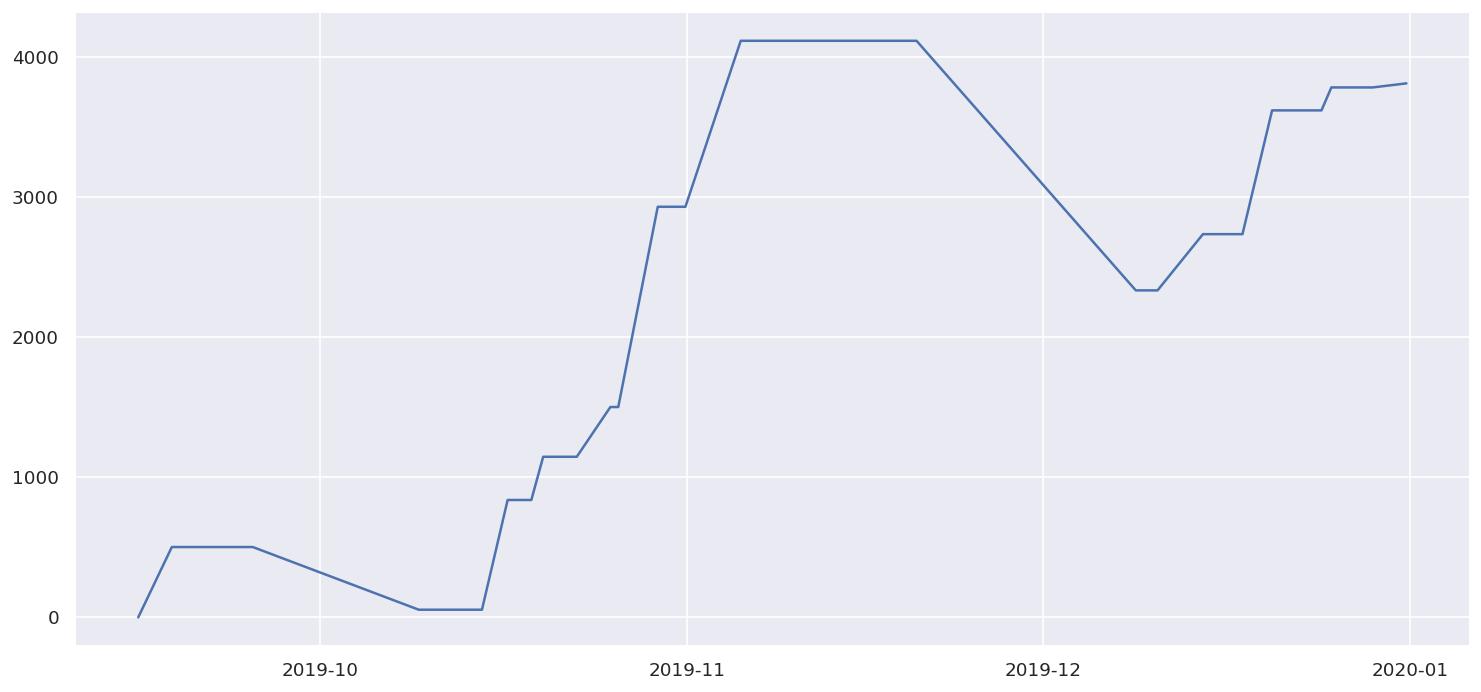

Profit/Loss: 3809.15
Maximum Drawdown: -2063.71
Maximum Holding Period: 18 days 12:00:00


In [39]:
train_results = showResults(txn)

---
## Out-Of-Sample Result

Trade on testing data using the best parameters and show the results

In [40]:
txn = trade(P1, P2, best[0], best[1], test=True)

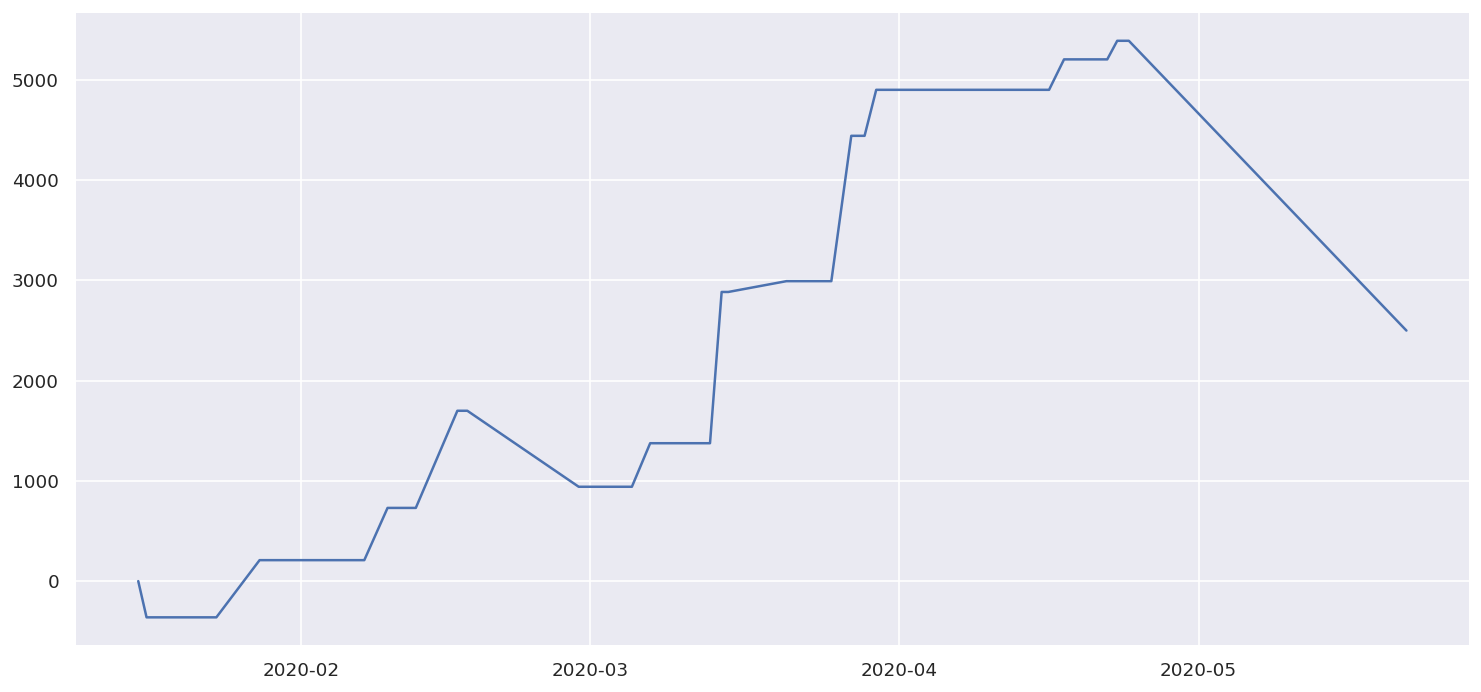

Profit/Loss: 2498.95
Maximum Drawdown: -3493.25
Maximum Holding Period: 27 days 20:00:00


In [41]:
test_results = showResults(txn)

---
## Transaction logs

Showing the transaction logs for validation purpose

### Transaction log for in-sample (train) dataset

In [42]:
train_results.head()

,action1,coin1,price1,qty1,action2,coin2,price2,qty2,zscore,hedgeratio,pnl,drawdown,holdingperiod
datetime,,,,,,,,,,,,,
2019-09-15 16:00:00,Sell,BTC,10317.72,-1,Buy,WIN,0.000228,4.517391e+07,1.050467,4.517391e+07,0.000000,0.000000,0 days 00:00:00
2019-09-18 12:00:00,Close,BTC,10150.52,-1,Close,WIN,0.000236,4.517391e+07,0.684146,4.304716e+07,501.486900,-264.666462,2 days 20:00:00
2019-09-25 08:00:00,Sell,BTC,8324.51,-1,Buy,WIN,0.000168,4.963930e+07,1.236442,4.963930e+07,501.486900,0.000000,0 days 00:00:00
2019-10-09 08:00:00,Close,BTC,8185.79,-1,Close,WIN,0.000156,4.963930e+07,0.641444,5.250667e+07,54.463203,-1590.758187,14 days 00:00:00
2019-10-14 16:00:00,Buy,BTC,8252.08,1,Sell,WIN,0.000159,-5.180213e+07,-1.012234,5.180213e+07,54.463203,0.000000,0 days 00:00:00


### Transaction log for out-of-sample (test) dataset

In [43]:
test_results.head()

,action1,coin1,price1,qty1,action2,coin2,price2,qty2,zscore,hedgeratio,pnl,drawdown,holdingperiod
datetime,,,,,,,,,,,,,
2020-01-15 16:00:00,Sell,BTC,8794.81,-1,Buy,WIN,0.000101,8.742356e+07,1.137314,8.742356e+07,0.000000,0.000000,0 days 00:00:00
2020-01-16 12:00:00,Close,BTC,8710.30,-1,Close,WIN,0.000095,8.742356e+07,0.732164,9.120733e+07,-361.350149,-361.350149,0 days 20:00:00
2020-01-23 12:00:00,Buy,BTC,8405.78,1,Sell,WIN,0.000103,-8.184791e+07,-1.119996,8.184791e+07,-361.350149,0.000000,0 days 00:00:00
2020-01-27 20:00:00,Close,BTC,8943.42,1,Close,WIN,0.000102,-8.184791e+07,-0.702283,8.742346e+07,209.029014,-225.401441,4 days 08:00:00
2020-02-07 08:00:00,Buy,BTC,9799.08,1,Sell,WIN,0.000127,-7.709740e+07,-1.052396,7.709740e+07,209.029014,0.000000,0 days 00:00:00


---
## Observations and Remarks

Although the strategy may work for pairs that are deemed statistically cointegrated, one will notice that it may not work all the time.  The strategy is too simplistic or robust enough to be a consistent profit generator.

There are many parameters or factors that can be considered and adjusted and like all automated trading strategies, these settings will need to be dynamically changed over time to align with the latest market conditions.

### Searching for cointegrated pairs using training data
Period and duration of training data used to determined the cointegrated pairs.  Longer historical time period could be used on the assumption that pairs that are deemed cointegrated will have a higher tendency of being cointegrated at least in the short-term future.

### Resampling of time series impact to strategy
Resampling of the time series to determined the cointegrated pairs is also important.  Pairs that are cointegrated pairs on 1 min time intervals may not be cointegrated on daily intervals.  Short time intervals translate to more trading opportunities and more data to determine which pairs are cointegrated at these time intervals.  However, this does not mean better profits.

### Back-testing of trading strategy
More backtestings and analysis are required to determine this strategy works with consistently.  This analysis is only done based on a single training and testing period.  Instead one can repeat this analysis on a rolling basis over a longer period to see for themselves whether the strategy really works in the long term.

### Maximum drawdown and holding period
In pair trading minimises risk by hedging one asset with another.  However, there is still risk involved if the deviation of the pair continues and does not converge fast enough.  This happens when the cointegration assumption is no longer valid, possibly due to specific events in any of the assets.  Maximum drawdown calculates the maximum loss one is exposed to at any one particular trade.  Note also that the longer it takes for the pair to converge, the longer the holding period, higher event risk the trade is exposed to.

### Cointegrated pairs changes over time
The advantage of this strategy is that it does not limit the assets that one use for trading.  Assets can be traded as long as they are deemed cointegrated and dropped the moment they are no longer cointegrated.

### Portfolio size, position sizing and quantity
The strategy currently, in the long trade, only buy 1 quantity of the 1st asset and hedge by selling with a fraction quantity of the 2nd asset.  Similarly, in the short trade, only sell 1 quantity of the 1st asset and hedge by buying a fraction quantity of the 2nd asset.  The fraction of quantity to buy or sell in the 2nd asset is determined by a hedge ratio (price of asset 1 / price of asset 2).  The hedge ratio calculation may not be optimal here and also the trade execution could be an issue if the quantity to trade is not a round number.  Portfolio size will be have introduced in order for this strategy to be more realistic.

### Trading multiple pair simultaneously
While the strategy is to trade only one pair here, this can be easily extended to multiple cointegrated pairs at the same time.  Different pairs can be tuned to respective optimal parameters.  All within a portfolio with nett exposures constrained by portfolio size.


---
## Future Work

1. Correlation analysis of cryptocurrencies pairs
2. Multiple cointegrated pairs trading
3. Portfolio size adjustments
4. Optimal time resampling selection
5. Optimal hedge ratio and realistic sizing of positions

## Reference

1. https://medium.com/auquan/pairs-trading-data-science-7dbedafcfe5a